# How to use pyransac, simplest case

In [1]:
#First, some visualization functions
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pyransac
from time import time
from copy import deepcopy

#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
def draw_matches(kps1, kps2, tentatives, img1, img2, H, mask):
    if H is None:
        print ("No homography found")
        return
    matchesMask = mask.ravel().tolist()
    h,w,ch = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, H)
    #print (dst)
    #Ground truth transformation
    dst_GT = cv2.perspectiveTransform(pts, H_gt)
    img2_tr = cv2.polylines(decolorize(img2),[np.int32(dst)],True,(0,0,255),3, cv2.LINE_AA)
    img2_tr = cv2.polylines(deepcopy(img2_tr),[np.int32(dst_GT)],True,(0,255,0),3, cv2.LINE_AA)
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(decolorize(img1),kps1,img2_tr,kps2,tentatives,None,**draw_params)
    plt.figure()
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(img_out, interpolation='nearest')
    return

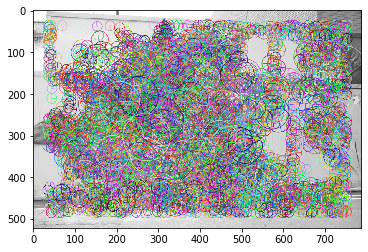

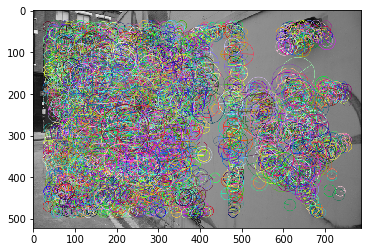

In [2]:
#Lets load some images and detect some featues
# Images are from HSequences dataset  https://github.com/hpatches/hpatches-dataset
img1 = cv2.cvtColor(cv2.imread('img/v_dogman/1.ppm'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('img/v_dogman/6.ppm'), cv2.COLOR_BGR2RGB)


H_gt =np.loadtxt('img/v_dogman/H_1_6')

# SIFT is not available by pip install, so lets use AKAZE features
det = cv2.AKAZE_create(descriptor_type = 3, threshold=0.00001)
kps1, descs1 = det.detectAndCompute(img1,None)
kps2, descs2 = det.detectAndCompute(img2,None)


# AKAZE features output "detection" scale, which is 6x less than one used for descriptor
# For correct drawing, we increase it manually
for i in range(len(kps1)):
    kps1[i].size = 5*kps1[i].size
for i in range(len(kps2)):
    kps2[i].size = 5*kps2[i].size

vis_img1, vis_img2 = None,None
vis_img1 = cv2.drawKeypoints(cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY),kps1,vis_img1, 
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
vis_img2 = cv2.drawKeypoints(cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY),kps2,vis_img2, 
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(vis_img1)
plt.figure()
plt.imshow(vis_img2)

In [3]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(descs1,descs2, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [False for i in range(len(matches))]

# SNN ratio test
for i,(m,n) in enumerate(matches):
    if m.distance < 0.9*n.distance:
        matchesMask[i]=True
tentatives = [m[0] for i, m in enumerate(matches) if matchesMask[i] ]

In [4]:
#Now helper function for running homography RANSAC
def verify_cv2(kps1, kps2, tentatives, th = 4.0 , n_iter = 2000):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, th, 0.99, n_iter)
    print ('cv2 found {} inliers'.format(int(deepcopy(mask).astype(np.float32).sum())))
    return H, mask

def verify_pyransac(kps1, kps2, tentatives, th = 4.0,  n_iter = 2000):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    H, mask = pyransac.findHomography(src_pts, dst_pts, th, 0.99, n_iter)
    print ('pyransac found {} inliers'.format(int(deepcopy(mask).astype(np.float32).sum())))
    return H, mask

cv2 found 40 inliers
0.04497  sec cv2
pyransac found 105 inliers
0.01185  sec pyransac


<Figure size 432x288 with 0 Axes>

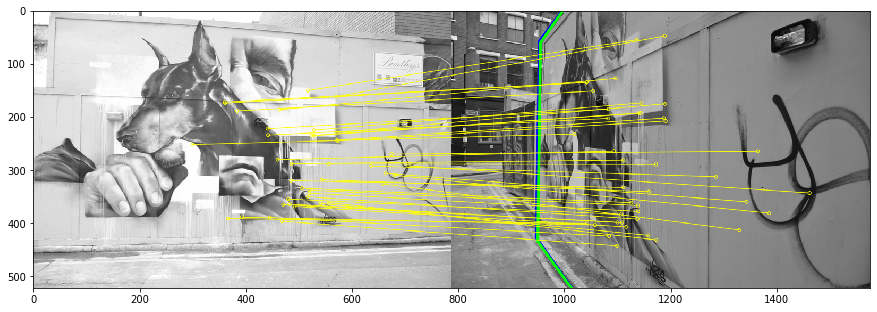

<Figure size 432x288 with 0 Axes>

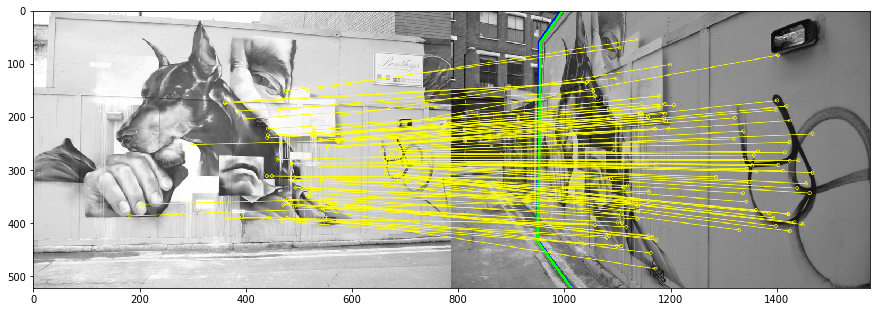

In [5]:
th = 4.0
n_iter = 2000

t=time()
cv2_H, cv2_mask = verify_cv2(kps1,kps2,tentatives, th, n_iter )
print ("{0:.5f}".format(time()-t), ' sec cv2')

t=time()
cmp_H, cmp_mask = verify_pyransac(kps1,kps2,tentatives, th, n_iter)
print ("{0:.5f}".format(time()-t), ' sec pyransac')


draw_matches(kps1, kps2, tentatives, img1, img2, cv2_H, cv2_mask)
draw_matches(kps1, kps2, tentatives, img1, img2, cmp_H, cmp_mask)

# Note, that OpenCV ransac uses a fixed random seed, while pyransac - not.
# That is why pyransac results differ from run to run, while the cv2 stay the same

In [6]:
help(pyransac.findFundamentalMatrix)

Help on function findFundamentalMatrix in module pyransac.utils:

findFundamentalMatrix(pts1_, pts2_, px_th=0.5, conf=0.9999, max_iters=100000, laf_consistensy_coef=-1.0, error_type='sampson', symmetric_error_check=True, enable_degeneracy_check=True)



In [9]:
#Now fundamental matrix
def verify_cv2_fundam(kps1, kps2, tentatives, th = 1.0 , n_iter = 10000):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    F, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.RANSAC, th, 0.999, n_iter)
    print ('cv2 found {} inliers'.format(int(deepcopy(mask).astype(np.float32).sum())))
    return F, mask

def verify_pyransac_fundam(kps1, kps2, tentatives, th = 1.0,  n_iter = 10000):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    F, mask = pyransac.findFundamentalMatrix(src_pts, dst_pts, th, 0.999, n_iter, enable_degeneracy_check= True)
    print ('pyransac found {} inliers'.format(int(deepcopy(mask).astype(np.float32).sum())))
    return F, mask

def draw_matches_F(kps1, kps2, tentatives, img1, img2, mask):
    matchesMask = mask.ravel().tolist()
    h,w,ch = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(decolorize(img1),kps1,
                              decolorize(img2),kps2,tentatives,None,**draw_params)
    plt.figure()
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(img_out, interpolation='nearest')
    return

cv2 found 18 inliers
0.03329  sec cv2
pyransac found 64 inliers
0.23564  sec pyransac


<Figure size 432x288 with 0 Axes>

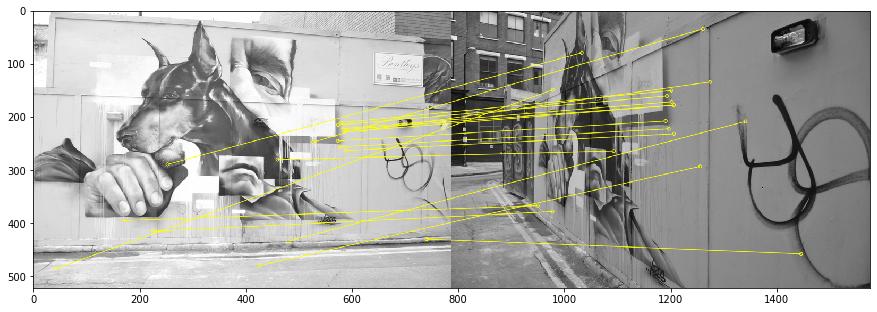

<Figure size 432x288 with 0 Axes>

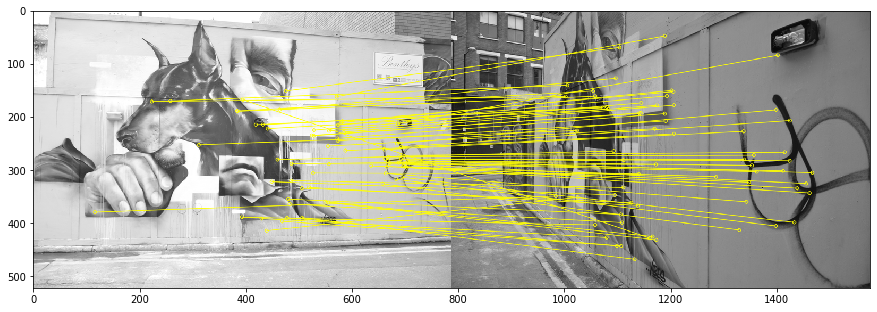

In [18]:
th = 0.5
n_iter = 50000

t=time()
cv2_H, cv2_mask = verify_cv2_fundam(kps1,kps2,tentatives, th, n_iter )
print ("{0:.5f}".format(time()-t), ' sec cv2')

t=time()
cmp_H, cmp_mask = verify_pyransac_fundam(kps1,kps2,tentatives, th, n_iter)
print ("{0:.5f}".format(time()-t), ' sec pyransac')


draw_matches_F(kps1, kps2, tentatives, img1, img2, cv2_mask )
draw_matches_F(kps1, kps2, tentatives, img1, img2, cmp_mask)

In [19]:
help(cv2.findFundamentalMat)

Help on built-in function findFundamentalMat:

findFundamentalMat(...)
    findFundamentalMat(points1, points2[, method[, ransacReprojThreshold[, confidence[, mask]]]]) -> retval, mask
    .   @brief Calculates a fundamental matrix from the corresponding points in two images.
    .   
    .   @param points1 Array of N points from the first image. The point coordinates should be
    .   floating-point (single or double precision).
    .   @param points2 Array of the second image points of the same size and format as points1 .
    .   @param method Method for computing a fundamental matrix.
    .   -   **CV_FM_7POINT** for a 7-point algorithm. \f$N = 7\f$
    .   -   **CV_FM_8POINT** for an 8-point algorithm. \f$N \ge 8\f$
    .   -   **CV_FM_RANSAC** for the RANSAC algorithm. \f$N \ge 8\f$
    .   -   **CV_FM_LMEDS** for the LMedS algorithm. \f$N \ge 8\f$
    .   @param ransacReprojThreshold Parameter used only for RANSAC. It is the maximum distance from a point to an epipolar
    .   l

skimage found 48 inliers
3.49348  sec skimage
cv2 found 25 inliers
0.02197  sec cv2


<Figure size 432x288 with 0 Axes>

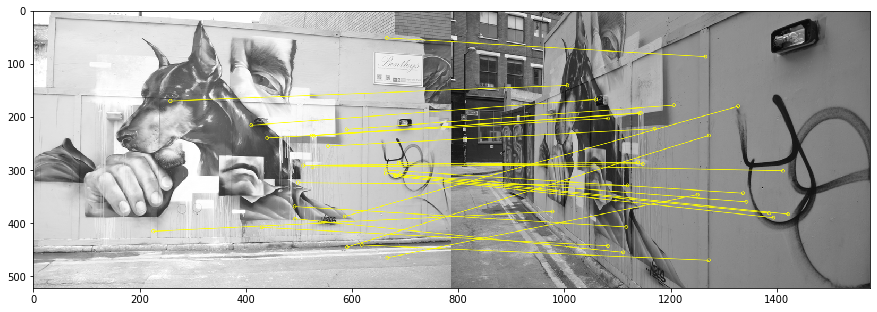

<Figure size 432x288 with 0 Axes>

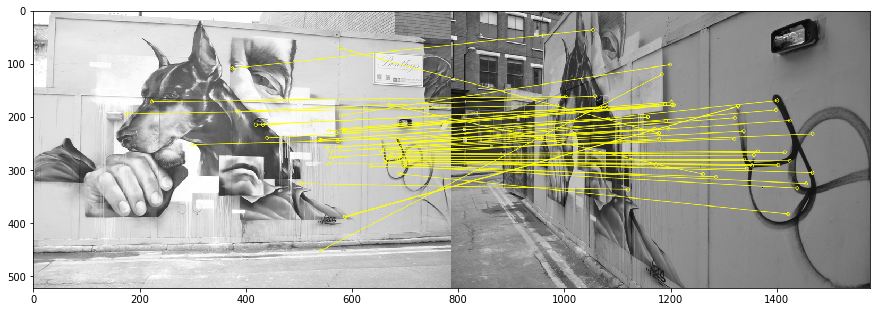

In [20]:
from skimage.measure import ransac as skransac
from skimage.transform import FundamentalMatrixTransform

def verify_skimage_fundam(kps1, kps2, tentatives, th = 4.0 , conf = 0.99):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    F, mask = skransac((src_pts, dst_pts),
                        FundamentalMatrixTransform, min_samples=8,
                        residual_threshold=th, stop_probability=conf, max_trials=10000)
    print ('skimage found {} inliers'.format(int(deepcopy(mask).astype(np.float32).sum())))
    return F, mask
def verify_cv2_fundam(kps1, kps2, tentatives, th = 4.0 , conf = 0.99):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    F, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.RANSAC, th, conf,)
    print ('cv2 found {} inliers'.format(int(deepcopy(mask).astype(np.float32).sum())))
    return F, mask

t=time()
th=1.0
conf=0.9999
sk_F, sk_mask = verify_skimage_fundam(kps1,kps2,tentatives, th, conf)
print ("{0:.5f}".format(time()-t), ' sec skimage')
t=time()
cv2_F, cv2_mask = verify_cv2_fundam(kps1,kps2,tentatives, th, conf )
print ("{0:.5f}".format(time()-t), ' sec cv2')

draw_matches_F(kps1, kps2, tentatives, img1, img2, cv2_mask )
draw_matches_F(kps1, kps2, tentatives, img1, img2, sk_mask)